In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.cgamma import c_multi_gamma_prob, c_multi_gamma_sf, c_multi_gamma_sf_approx
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [2]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [3]:
dist = 2
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

xvals = np.linspace(-30, 30, 100000)

[1.00045562 1.2639036  1.00001584] [0.04895381 1.50627305 0.00372613]


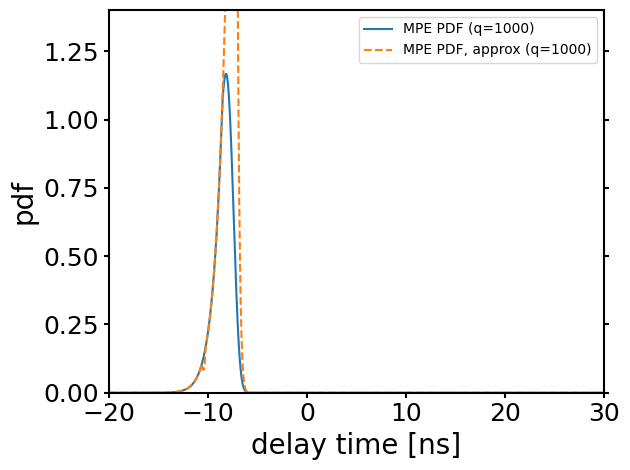

In [4]:
c_multi_gamma_prob_vx = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0))
c_multi_gamma_sf_vx = jax.jit(jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0))
c_multi_gamma_sf_approx_vx = jax.jit(jax.vmap(c_multi_gamma_sf_approx, (0, None, None, None, None), 0))

n_p = 1000

fig, ax = plt.subplots()
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_approx = c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0)

yval1 = n_p * probs * jnp.power(sfs, n_p-1)
ymax = np.max(yval1)
plt.plot(xvals, yval1, label=f'MPE PDF (q={n_p})')

yval2 = n_p * probs * jnp.power(sfs_approx, n_p-1)
plt.plot(xvals, yval2, label=f'MPE PDF, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 1.2 * ymax],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()



In [5]:
#%timeit c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1).block_until_ready()

In [6]:
#%timeit c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0).block_until_ready()

In [7]:
#%timeit c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0).block_until_ready()

In [8]:
print(probs)

[5.13425424e-24 5.14462173e-24 5.15500996e-24 ... 1.20819429e-03
 1.20816127e-03 1.20812826e-03]


In [9]:
n_photons = 1000
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_approx = c_multi_gamma_sf_approx_vx(xvals, mix_probs, g_a, g_b, 3.0)
mpe_log_probs = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs)
mpe_log_probs_approx = jnp.log(n_photons) + jnp.log(probs) + (n_photons-1.0) * jnp.log(sfs_approx)

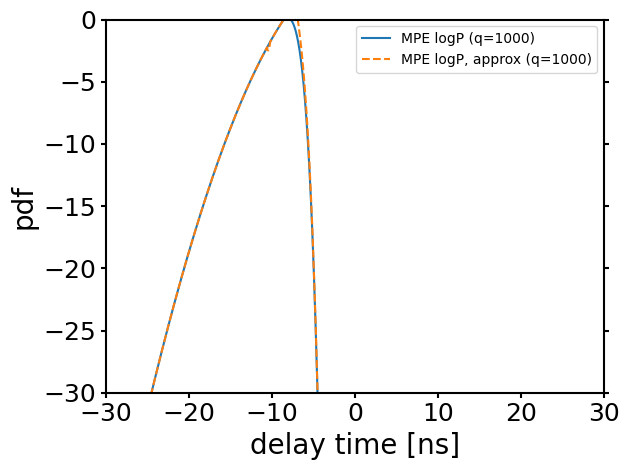

In [10]:
fig, ax = plt.subplots()

plt.plot(xvals, mpe_log_probs, label=f'MPE logP (q={n_p})')
plt.plot(xvals, mpe_log_probs_approx, label=f'MPE logP, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-30, 30],
                     'ylim':[-30, 0.0],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [11]:
xvals = np.linspace(-20, 0.0, 100000)
yval1 = n_p * probs * jnp.power(sfs, n_p-1)
dx = xvals[1] - xvals[0]
print(dx)

0.00020000200002101565


In [12]:
print(jnp.sum(yval1) * dx)

0.7969046805480237


In [13]:
@jax.jit
def compute_mpe_pdf(x):
    prob = c_multi_gamma_prob(x, mix_probs, g_a, g_b, 3.0, 0.1)
    sf = c_multi_gamma_sf(x, mix_probs, g_a, g_b, 3.0)
    return n_p * prob * jnp.power(sf, n_p-1)

In [14]:
print(compute_mpe_pdf(0.0))

1.5625176760015545e-185


In [15]:
from scipy.integrate import quad

In [16]:
print(quad(compute_mpe_pdf, -20, 0.0))

(2.3907140369942605, 2.9628142806652893e-08)


In [17]:
def c_gamma_sf(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    #alpha = 2.5 # controls the split of the integral => precision.
    alpha = 2.5
    n_steps = 40 # controls the support points in midpoint integration
    eps = 1.e-15

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)

    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0)

    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    x_int = 0.5*(x_int[...,1:] + x_int[...,:-1])
    dx = jnp.expand_dims(x_int[..., 1] - x_int[..., 0], axis=-1)

    # add dimension to end for proper broadcasting during integration
    # and then integrate by brute force on even grid
    # todo: come up with something faster and more accurate?
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= jnp.sum(y_int * dx, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=eps, max=1.0)

def c_multi_gamma_sf(x, mix_probs, a, b, sigma=3.0):
    probs = c_gamma_sf(x, a, b, sigma=sigma)
    print(probs)
    return jnp.sum(mix_probs * probs, axis=-1)

def c_gamma_sf_quadax(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    #alpha = 2.5 # controls the split of the integral => precision.
    alpha = 2.5
    n_steps = 100 # controls the support points in midpoint integration
    eps = 1.e-15

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)

    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0)

    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    #x_int = 0.5*(x_int[...,1:] + x_int[...,:-1])
    #dx = jnp.expand_dims(x_int[..., 1] - x_int[..., 0], axis=-1)

    # add dimension to end for proper broadcasting during integration
    # and then integrate by brute force on even grid
    # todo: come up with something faster and more accurate?
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    #term2 *= jnp.sum(y_int * dx, axis=-1)
    term2 *= quadax.simpson(y_int, x=x_int, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=eps, max=1.0)

def c_multi_gamma_sf_quadax(x, mix_probs, a, b, sigma=3.0):
    probs = c_gamma_sf_quadax(x, a, b, sigma=sigma)
    return jnp.sum(mix_probs * probs, axis=-1)

In [18]:
print(c_multi_gamma_sf(3.0, mix_probs, g_a, g_b))
print(c_multi_gamma_sf_quadax(3.0, mix_probs, g_a, g_b))

[0.85983117 0.23558341 0.98801247]
0.3172598758919659
0.3299161099336686


In [19]:
print(mix_probs)

[0.0980343  0.87474882 0.02721688]


In [20]:
import quadax
c_multi_gamma_prob_vx = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0))
c_multi_gamma_sf_vx = jax.jit(jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0))
c_multi_gamma_sf_quadax_vx = jax.jit(jax.vmap(c_multi_gamma_sf_quadax, (0, None, None, None, None), 0))

Traced<ShapedArray(float64[3])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[100000,3])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0


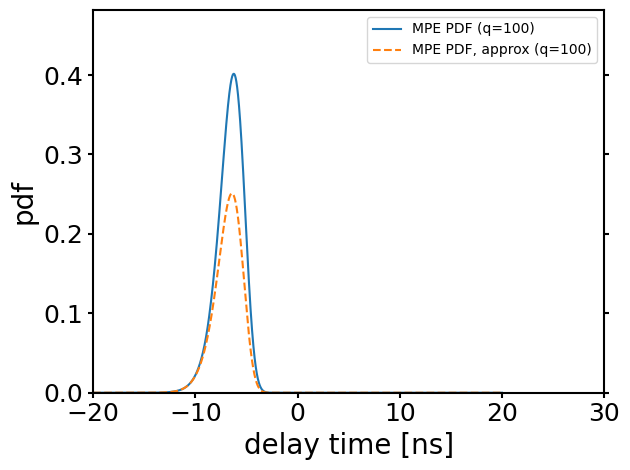

In [21]:
n_p = 100
xvals = np.linspace(-20, 20.0, 100000)

fig, ax = plt.subplots()
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_quadax = c_multi_gamma_sf_quadax_vx(xvals, mix_probs, g_a, g_b, 3.0)

yval1 = n_p * probs * jnp.power(sfs, n_p-1)
ymax = np.max(yval1)
plt.plot(xvals, yval1, label=f'MPE PDF (q={n_p})')

yval2 = n_p * probs * jnp.power(sfs_quadax, n_p-1)
plt.plot(xvals, yval2, label=f'MPE PDF, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 1.2 * ymax],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [22]:
print(sfs)
print(sfs_quadax)

[1.         1.         1.         ... 0.06251249 0.06251172 0.06251095]
[1.         1.         1.         ... 0.06251128 0.06251052 0.06250975]


In [23]:
@jax.jit
def compute_mpe_pdf_quadax(x):
    prob = c_multi_gamma_prob(x, mix_probs, g_a, g_b, 3.0, 0.1)
    sf = c_multi_gamma_sf_quadax(x, mix_probs, g_a, g_b, 3.0)
    return n_p * prob * jnp.power(sf, n_p-1)

@jax.jit
def compute_mpe_pdf(x):
    prob = c_multi_gamma_prob(x, mix_probs, g_a, g_b, 3.0, 0.1)
    sf = c_multi_gamma_sf(x, mix_probs, g_a, g_b, 3.0)
    return n_p * prob * jnp.power(sf, n_p-1)

In [24]:
print(quad(compute_mpe_pdf, -15, 10))
print(quad(compute_mpe_pdf_quadax, -15, 10))

Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=1/0)>
(1.2219705130627652, 1.2323147038486286e-08)
(0.8043122609347978, 8.226039977961602e-09)


In [25]:
from quadax import quadgk

In [26]:
print(quadgk(compute_mpe_pdf, [-15, 10]))
print(quadgk(compute_mpe_pdf_quadax, [-15, 10]))

Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>
(Array(1.22197051, dtype=float64), QuadratureInfo(err=Array(1.40236437e-08, dtype=float64), neval=Array(525, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
(Array(0.80431226, dtype=float64), QuadratureInfo(err=Array(3.99793953e-09, dtype=float64), neval=Array(441, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))


In [27]:
def integrand(x, a, b, x0, sqrt2sigma2):
    return jnp.power(x, a-1) * jnp.exp(-b*x) * erf((x0-x)/sqrt2sigma2)

def c_gamma_sf_quadax_quad(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    #alpha = 2.5 # controls the split of the integral => precision.
    alpha = 2.5
    eps = 1.e-15

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)

    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0)

    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    cond = ymax >= 0.0
    
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)

    ymax = jnp.where(ymax >= 0.0, ymax, 0.1)
    res = quadgk(integrand, jnp.array([ymin, ymax]), args=(a, b, x, sqrt2sigma2), 
                 epsabs=1.e-5, 
                 epsrel=1.e-5, 
                 order=21,
                 max_ninter=1)[0]
    
    term2 *= jnp.where(cond, res, 0.0)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=eps, max=1.0)

def c_multi_gamma_sf_quadax_quad(x, mix_probs, a, b, sigma=3.0):
    probs = c_gamma_sf_quadax_quad(x, a, b, sigma=sigma)
    print(probs)
    return jnp.sum(mix_probs * probs, axis=-1)

c_multi_gamma_sf_quadax_quad_vx = jax.jit(jax.vmap(c_multi_gamma_sf_quadax_quad, (0, None, None, None, None), 0))

In [28]:
print(c_multi_gamma_sf_quadax_quad(-30.0, mix_probs, g_a, g_b))

[1. 1. 1.]
1.0


In [29]:
print(c_multi_gamma_sf(-12.0, mix_probs, g_a, g_b))

[1. 1. 1.]
1.0


In [30]:
print(mix_probs)

[0.0980343  0.87474882 0.02721688]


/home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Traced<ShapedArray(float64[3])>with<BatchTrace(level=2/0)> with
  val = Traced<ShapedArray(float64[100000,3])>with<DynamicJaxprTrace(level=1/0)>
  batch_dim = 0


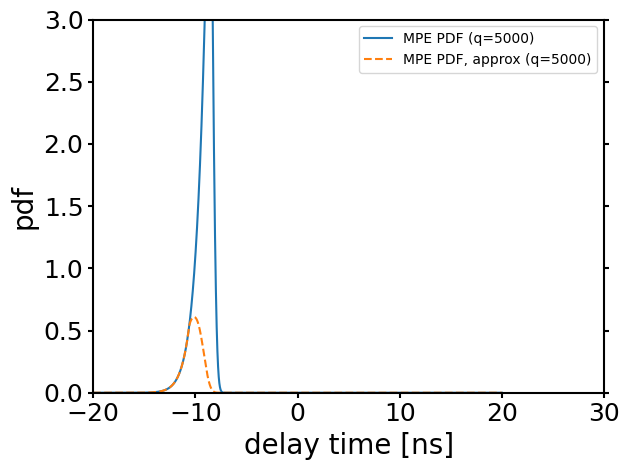

In [31]:
n_p = 5000
xvals = np.linspace(-20, 20.0, 100000)

fig, ax = plt.subplots()
probs = c_multi_gamma_prob_vx(xvals, mix_probs, g_a, g_b, 3.0, 0.1)
sfs = c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)
sfs_quadax = c_multi_gamma_sf_quadax_quad_vx(xvals, mix_probs, g_a, g_b, 3.0)

yval1 = n_p * probs * jnp.power(sfs, n_p-1)
ymax = np.max(yval1)
plt.plot(xvals, yval1, label=f'MPE PDF (q={n_p})')

yval2 = n_p * probs * jnp.power(sfs_quadax, n_p-1)
plt.plot(xvals, yval2, label=f'MPE PDF, approx (q={n_p})', linestyle='dashed')

plot_args = {'xlim':[-20, 30],
                     'ylim':[0.0, 3.0],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [32]:
%timeit c_multi_gamma_sf_vx(xvals, mix_probs, g_a, g_b, 3.0)

14.9 ms ± 8.92 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
%timeit c_multi_gamma_sf_quadax_quad_vx(xvals, mix_probs, g_a, g_b, 3.0)

22 ms ± 143 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
@jax.jit
def compute_mpe_pdf_quadax_quad(x):
    prob = c_multi_gamma_prob(x, mix_probs, g_a, g_b, 3.0, 0.1)
    sf = c_multi_gamma_sf_quadax_quad(x, mix_probs, g_a, g_b, 3.0)
    return n_p * prob * jnp.power(sf, n_p-1)

@jax.jit
def compute_mpe_pdf(x):
    prob = c_multi_gamma_prob(x, mix_probs, g_a, g_b, 3.0, 0.1)
    sf = c_multi_gamma_sf(x, mix_probs, g_a, g_b, 3.0)
    return n_p * prob * jnp.power(sf, n_p-1)

In [35]:
print(quadgk(compute_mpe_pdf, [-20, 10]))
print(quadgk(compute_mpe_pdf_quadax_quad, [-20, 10]))

Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>
(Array(6.4630562, dtype=float64), QuadratureInfo(err=Array(3.87439818e-08, dtype=float64), neval=Array(609, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=3/0)>


/home/hans/.local/share/virtualenvs/py3_jax_latest-mr9UFGRS/lib/python3.11/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


(Array(1.2915083, dtype=float64), QuadratureInfo(err=Array(1.36101592e-08, dtype=float64), neval=Array(525, dtype=int64, weak_type=True), status=Array(0, dtype=int64, weak_type=True), info=None))
